# Intelligent Tourist Guide

***Gaizka Menéndez Hernández***

The goal of this project is to build an intelligent tourist agent based on  Retrieval-Augmented Generation (RAG) models. This system is designed to help tourists with well founded and reliable knowledge about 5 destinations from Spain (Barcelona, Bilbao, Tenerife, Valencia and Vigo) and the weather forecast that will be found in those places.

## Dependencies installation

We install the main dependencies that will be used alongside this notebook like LangChain, langgraph, google-genai, pypdf2, ...

In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Load the Google API

First we load the .env file by using load_dotenv() with the corresponding API's that we're going to use to make the corresponding calls to the models.

In [2]:
import os, getpass
from dotenv import load_dotenv

# cargamos las variables/claves desde el .env
dotenv_loaded = load_dotenv()

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Google API Key was not set properly, please share it here: ")
    
if not os.environ.get("OPENWEATHER_API_KEY"):
    os.environ["OPENWEATHER_API_KEY"] = getpass.getpass("OpenWeather API Key was not set properly, please share it here: ")
    
# comprobamos que se han cargado correctamente
if os.environ["GOOGLE_API_KEY"]=="" or os.environ["OPENWEATHER_API_KEY"]=="":
    print("'GOOGLE_API_KEY' wasn't set correctly. Please make sure the keys/variables are accesible")

Let's make a little trial to ensure the API key is valid.

In [3]:
from google import genai

client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents="Dime quien es el máximo goleador vasco de LaLiga en la temporada 2020-2021",
)

print(response.text)

El máximo goleador vasco de LaLiga en la temporada 2020-2021 fue **Mikel Oyarzabal** de la Real Sociedad, con **11 goles**.


## Data Preprocessing

We use a set of PDFs located in the data folder. These documents contain the touristic information of the cities mentioned above, which we wish to advise on to tourists. 

Firstly we will load and parse the text from each of the documents so it can go through our RAG pipeline. Later divide the global text in chunks so it's more manageable. To do this, we implemented a helper function that iterates through each file, splits it into pages, and extracts the textual content. For this purpose we are using the [PyPDF2](https://pypi.org/project/PyPDF2/) library.

In [4]:
from PyPDF2 import PdfReader

def document_reader(path, doc_name):
    
    # Abrimos el archivo para leerlo de forma binaria
    doc_path = path + doc_name
    pdf_reader = PdfReader(doc_path)
    
    global_text = []
    for i, page in enumerate(pdf_reader.pages, start=1):
        text = page.extract_text()
        # global_text[pdf_reader.pages[i].extract_text()] = {f"Page {i+1}": f"{doc_name}"}
        
        global_text.append({
            "page_content": text.strip(), # limpia espacios sobrentes y los saltos de linea
            "doc_ubication": { "document": doc_name, "page": i }
        })
        
    return global_text  

Now, by using function above we will create a list mixing everything in an only list so we have all the chunks/pages together and can operate easily.

In [5]:
def load_pdfs(data_dir="../data/"):
    documents = []
    for file in os.listdir("../data/"): # recorremos la lista de archivos en el directorio y aplicamos document_reader a cada uno de ellos
        docs = document_reader(data_dir, file)
        documents.extend(docs)
    return documents

documents = load_pdfs("../data/")
print(len(documents), documents[0]["doc_ubication"])
print(documents[-1]["doc_ubication"])


121 {'document': 'BARCELONA.pdf', 'page': 1}
{'document': 'VIGO.pdf', 'page': 28}


Now we will split up everything on chunks. Each document will be having around of 40.000 characters what is a extremely large quantity if we take the whole sum of characters for every document on the data folder. Furthermore, it is not very convenient for adding them to the context window of some models, it may be difficult for these models to find the information in excessively long inputs (not to mention the increased cost of each request to the model...). Easier to manage and no-lost relevant information found at the boundaries between chunks due to the overlap thanks to the overlap used to preserve it.

That's why we will use `RecursiveCharacterTextSplitter` to divide the format following a recursive strategy in the chunk_size we decide. The raw text is available is divided into chunks of approximately 1,000 characters with an overlap of 200 characters. We obtain a standardized collection of Document objects enriched with metadata (source file and page number).

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import Document

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    # separators=["\n\n", "\n", ". ", " ", ""],
    add_start_index=True
)

docs = [Document(page_content=d["page_content"], metadata=d["doc_ubication"]) for d in documents]

docs_splitted = text_splitter.split_documents(docs)

print(f"Total splits: {len(docs_splitted)}")

# Mostramos el primer split.
print(f"First split content:\n{docs_splitted[0]}\n")

Total splits: 264
First split content:
page_content='www.spain.infoBarcelona' metadata={'document': 'BARCELONA.pdf', 'page': 1, 'start_index': 0}



In [7]:
print(f"Second split content:\n{docs_splitted[1].page_content}\n")

Second split content:
2
 Introducción 3
Vive Barcelona: principales zonas  4
  El Born 
  Gràcia y L´Eixample 
  Barrio Gótico 
  El Raval 
  Montjuïc 
  Plaça de Espanya 
  La Rambla 
  Basílica de la Sagrada Familia 
  Les Corts y Pedralbes 
Cultura  8
  Museos 
  Centros de exposiciones 
Saborea Barcelona  10
Barcelona en cada estación 12
  Verano 
  Otoño 
  Invierno 
  Primavera 
Playas 14
Cinco planes para disfrutar  15 
en familia
  PortAventura World 
  Parque de Atracciones Tibidabo 
  L ’Aquàrium 
  Zoo de Barcelona 
  Museu de la Música  
  Las Golondrinas La ciudad escondida 16
  Parques y jardines  
  Museos secretos 
  Monumentos  
  Los tejados de Barcelona 
Vivir la noche en Barcelona  19
Rutas y paseos por la ciudad 20
  Ruta romana 
  Ruta medieval 
  Ruta modernista 
  Ruta Gaudí 
  Ruta Miró 
  Ruta Picasso 
¿Qué visitar cerca de Barcelona? 23
  Ciudades y lugares de interés 
  Naturaleza 
¿Cómo llegar? 25
  AVE 
  Aeropuerto 
  Coche 
  Moverte por Barcelona



Now that we have all the chunks generated, it's time to apply the embedding and to save them inside a vector store. The text of each chunk is transformed into a high-dimensional numerical vector using an embedding model, representing the semantic meaning of the text. The vectors are stored in a specialised database, FAISS (Facebook AI Similarity Search), which is optimised for fast k-nearest neighbour searches. This improves natural language information retrieval.

We will use a vector store defined in memory and to generate the embeddings we will be using google embedding models.

In [8]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [9]:
from langchain_community.vectorstores import FAISS

vector_store = FAISS.from_documents(docs_splitted, embedding=embeddings)
document_ids = vector_store.add_documents(documents=docs_splitted)

print(document_ids[:3])

['8128257a-ba57-42a4-8af6-81f6dc06235b', '17a309bd-fb1b-49e8-8a1a-d02084d7cea3', '87563e9a-4702-43c5-bdd6-adeada44442e']


## Baseline RAG Example

Before implementing the full agent we test a minimal RAG pipeline where given a basic prompt and using the similarity_search() function to find the 4 most relevant extracts from the vector store and pass them directly to the LLM (Gemini 2.0 Flash). This help us verify the previous steps in the data preparation section where correctly taken.

In [10]:
from langchain_core.prompts import PromptTemplate

rag_prompt = PromptTemplate.from_template(
    "You are a precise tourist guide. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. Always cite sources as as provided in the context. \n" +
    "Question: {question}\n" +
    "Context: {context}\n" +
    "Answer: "
)

In [11]:
from langchain.chat_models import init_chat_model

tourist_guide_llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [12]:
question = "que puedo ver en Bilbao?"

retrieved_docs = vector_store.similarity_search(question, k=4)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

print(f"Retrieved context:\n{retrieved_docs}\n")

Retrieved context:
[Document(id='0d0eb658-a782-4783-b0a0-02a9c2c9d13d', metadata={'document': 'BILBAO.pdf', 'page': 1, 'start_index': 0}, page_content='www.spain.infoBilbao'), Document(id='a7fc2994-7d62-489f-a4b2-100384519ebe', metadata={'document': 'BILBAO.pdf', 'page': 1, 'start_index': 0}, page_content='www.spain.infoBilbao'), Document(id='23fa005b-a69d-4e7e-8bd6-783e02ade25d', metadata={'document': 'BARCELONA.pdf', 'page': 1, 'start_index': 0}, page_content='www.spain.infoBarcelona'), Document(id='8128257a-ba57-42a4-8af6-81f6dc06235b', metadata={'document': 'BARCELONA.pdf', 'page': 1, 'start_index': 0}, page_content='www.spain.infoBarcelona')]



In [13]:
def format_docs_with_citations(docs):
    parts = []
    for d in docs:
        src = d.metadata.get("source", "unknown").split("/")[-1]
        page = d.metadata.get("page", "NA")
        parts.append(f"{d.page_content}\n[Source: {src} Page: {page}]")
    return "\n\n---\n\n".join(parts)


In [14]:
# context = format_docs_with_citations(retrieved_docs)
input = rag_prompt.invoke({"question": question, "context": docs_content})
print(f"Input for the LLM:\n{input.text}\n")

Input for the LLM:
You are a precise tourist guide. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. Always cite sources as as provided in the context. 
Question: que puedo ver en Bilbao?
Context: www.spain.infoBilbao

www.spain.infoBilbao

www.spain.infoBarcelona

www.spain.infoBarcelona
Answer: 



In [15]:
answer = tourist_guide_llm.invoke(input)
print(f"LLM answer:\n{answer.content}\n")

LLM answer:
I don't have enough information to answer what you can see in Bilbao. The provided context only contains URLs for tourism information about Bilbao and Barcelona from spain.info (www.spain.infoBilbao, www.spain.infoBarcelona). To find out what you can see in Bilbao, please visit www.spain.infoBilbao.



Now after trying each step separatedly we can build the chat by combining the retrieval part with the LLM use.

In [17]:
def ask_tguide(question: str, prompt, vector_store):
    
    retrieved_docs = vector_store.similarity_search(question, k=4)
    context = format_docs_with_citations(retrieved_docs)
    input = prompt.invoke({"question": question, "context": context})
    return tourist_guide_llm.invoke(input).content


print(ask_tguide("¿Me propones un itinerario de 1 día por Tenerife norte?", rag_prompt, vector_store))

I can suggest visiting the Auditorio de Tenerife and Plaza de España for a 1-day itinerary in northern Tenerife (unknown Page: 2). You can find videos and locations for both online (unknown Page: 2).


## LangGraph Agent solution

Our first solution will be an Agent created with LangGraph. Here it's important to remark that we created two functions, one to retrieve certain information from the documents and another one to get the weather from the destination asked. The agent will be provided with both and it will decide depending on the tourist question.

In [18]:
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(MessagesState)

Here are defined both tools mentioned before.

* For the retrieve function, we choose the 30 chunks more relevant to the query with a semantic search (vector_store.as_retriever()). Those 30 chunks are passed to a reranking model and a cross-encoder, for this case I used the one considered standard for information retrieval purposes. It evaluates query and document together to calculate a relevancy score. it chooses the best 4 scores and sends them to the LLM.

* On the other hand, the get_weather_function, it uses an open API (OpenMeteo) to determine the forecast in an specific longitude and latitude. Here the filter is set to only let the function calculate the forecast from one of the destinations. It makes no sense to give the weather from a place from we are not giving a touristic service.

In [19]:
import os, requests, json
from langchain_core.tools import tool
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain.retrievers import ContextualCompressionRetriever


# coordenadas de los centros de cada destino (mas o menos), es para hacer las requests a la API Open-Meteo
CITY_COORDS = {
        "barcelona": {"lat": 41.3879, "lon": 2.16992},     
        "bilbao": {"lat": 43.2630, "lon": -2.9350},        
        "tenerife": {"lat": 28.2916, "lon": -16.6291},     
        "valencia": {"lat": 39.4699, "lon": -0.3763},      
        "vigo": {"lat": 42.2406, "lon": -8.7207},          
    }

# usamos similarity search + rearnking con cross encoder porque está demostrado que para mayor precisión usar este es optimo
base_retriever = vector_store.as_retriever(search_kwargs={"k": 30})
cross_encoder = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")
reranker = CrossEncoderReranker(model=cross_encoder, top_n=4)
retriever = ContextualCompressionRetriever(base_retriever=base_retriever, base_compressor=reranker)

# Vamos a definir una funcion que determine el tiempo en las ciudades que conoce el RAG, no tiene sentido que sepa el tiempo de una que no conozca.
@tool("get_weather", description="Returns the forecast obtained from Open-Meteo for a date YYYY-MM-DD and city supported")
def get_weather(date: str, city: str, tz: str = "Europe/Madrid"):
    
    url = "https://api.open-meteo.com/v1/forecast"
    c = city.lower()
    if c not in CITY_COORDS:
        return {"ok": False, "error": "Ciudad no soportada"}
    lat, lon = CITY_COORDS[c]["lat"], CITY_COORDS[c]["lon"]
    
    params = {
        "latitude": lat,
        "longitude": lon,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,weathercode",
        "timezone": tz,
        "start_date": date,
        "end_date": date,
    }
    
    r = requests.get(url, params=params)
    if r.status_code != 200:
        return {"ok": False, "error": f"HTTP {r.status_code}"}
    d = r.json()["daily"]
    
    return {
        "fecha": date,
        "ciudad": city,
        "tmax": d.get("temperature_2m_max", [None])[0],
        "tmin": d.get("temperature_2m_min", [None])[0],
        "lluvia_mm": d.get("precipitation_sum", [None])[0],
        "weathercode": d.get("weathercode", [None])[0],
    }


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    
    # Cambiamos de get_relevant_documents a invoke porque me daba un warning que nos devolvía cuando ejecutamos la celda de prueba y ensuciaba la salida de la celda:
    #  LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
    # retrieved_docs = retriever.get_relevant_documents(query)
    retrieved_docs = retriever.invoke(query)
    # retrieved_docs = vector_store.similarity_search(query, k=2)
    
    if not retrieved_docs:
        return "Could'nt find any relevant information for the query.", []
    
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

print(get_weather.invoke({"date": "2025-09-10", "city": "Bilbao"}))

result = retrieve.invoke({"query": "Qué ver en Bilbao"})

{'fecha': '2025-09-10', 'ciudad': 'Bilbao', 'tmax': 23.7, 'tmin': 17.1, 'lluvia_mm': 1.5, 'weathercode': 53}


The prompt below was adapted and refined to fit the specific requirements of the project (destinations restriction and only relevant questions for a tourist guide).

In [62]:
AGENT_SYSTEM_PROMPT = """
You are a tourist guide for only five Spanish destinations:
Barcelona, Bilbao, Galicia, Tenerife, and Valencia.

Answer only tourism-related questions about these places, anything else.
If the question is about another topic or city, politely refuse and insist on the idea you're a tourist guide.

Use `retrieve` for factual answers and `get_weather(date, city)` for weather.
If information is missing or not found in the retrieved documents, it's mandatory you say you don’t know.

Keep answers short (3–5 sentences), clear, and include citations if provided.

Context:
{retrieved_context}
""".strip()


In [66]:
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
     

def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond directly."""
    touristic_llm_with_tools = tourist_guide_llm.bind_tools([retrieve, get_weather])
    response = touristic_llm_with_tools.invoke(state["messages"])
    # MessagesState añade los mensajes al estado en lugar de sobrescribirlos.
    return {"messages": [response]}

tools = ToolNode([retrieve, get_weather])

def generate(state: MessagesState):
    """Generate answer."""
    # Obtenemos los mensajes con rol ToolMessage
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Formateamos el contenido en el prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = AGENT_SYSTEM_PROMPT.format(retrieved_context=docs_content)
    
    # (
    #     "You are a precise tourist guide. "
    #     "Use the following pieces of retrieved context to answer the question. "
    #     "If you don't know the answer, just say that you don't know. "
    #     "Use three sentences maximum and keep the answer concise."
    #     "\n\n"
    #     f"{docs_content}"
    # )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Generamos la respuesta final
    response = tourist_guide_llm.invoke(prompt)
    return {"messages": [response]}

After finishing every part definition we add everything to the graph. 

The entry point is query_or_respond, which decides whether to directly answer or call a tool.
If a tool call is required, control passes to the tools node, and afterwards to generate for the final response.
If no tool is needed, the graph ends immediately.

We compile without memory saving so the agent won't have context from previous questions made.

In [22]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

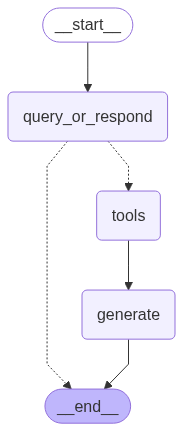

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Some examples:

In [24]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="updates"
):
    print(f"{step}\n\n-------------------------\n")

{'query_or_respond': {'messages': [AIMessage(content='Hi, how can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--3490bb5b-46e2-46a0-995e-68127b093065-0', usage_metadata={'input_tokens': 45, 'output_tokens': 10, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}})]}}

-------------------------



In [25]:
input_message = "What can I see in Barcelona for one day visit?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="updates"
):
    print(f"{step}\n\n-------------------------\n")

{'query_or_respond': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve', 'arguments': '{"query": "things to see in Barcelona for one day"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--69d3efe8-ddda-46ca-a84d-6e3948f9daba-0', tool_calls=[{'name': 'retrieve', 'args': {'query': 'things to see in Barcelona for one day'}, 'id': '49353eb2-0b69-448b-bb49-692b648703dc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 55, 'output_tokens': 10, 'total_tokens': 65, 'input_token_details': {'cache_read': 0}})]}}

-------------------------

{'tools': {'messages': [ToolMessage(content="Source: {'document': 'BARCELONA.pdf', 'page': 18, 'start_index': 806}\nContent: te frente a su estanque con cascada. T ó -\nmate una copa de vino mientras disfru -\ntas de las vistas en las terrazas que hay \ncerca del Mirador de los Jardines d

In [26]:
input_message = "What is the weather for tomorrow being the date 2025-09-08 in Bilbao?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="updates"
):
    print(f"{step}\n\n-------------------------\n")

{'query_or_respond': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Bilbao", "date": "2025-09-08"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--9446c577-c620-4305-b52b-03305811ab4f-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Bilbao', 'date': '2025-09-08'}, 'id': 'be15b1c9-7551-455c-ac44-273c8be89012', 'type': 'tool_call'}], usage_metadata={'input_tokens': 67, 'output_tokens': 17, 'total_tokens': 84, 'input_token_details': {'cache_read': 0}})]}}

-------------------------

{'tools': {'messages': [ToolMessage(content='{"fecha": "2025-09-08", "ciudad": "Bilbao", "tmax": 20.9, "tmin": 17.7, "lluvia_mm": 5.0, "weathercode": 63}', name='get_weather', id='a4d3a316-a493-4ea2-aefc-5ca543d0acd9', tool_call_id='be15b1c9-7551-455c-ac44-273c8be89012')]}}

-------------------------

{'

Now, we add the memory option with MemorySaver. This helps the model have a previous context of each question asked to him. This is done whit a config parameter where you can specify the id of the chat and every question done there.

In [67]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Debemos especificar un ID para el hilo de conversación
config = {"configurable": {"thread_id": "00001"}}

In [56]:
input_message = "Cual es el mejor sitio para ir a comer en Tenerife para comer arepas?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Cual es el mejor sitio para ir a comer en Tenerife para comer arepas?
================================== Ai Message ==================================
Tool Calls:
  retrieve (fc7d3c54-067c-4dce-8817-d7393aa24e45)
 Call ID: fc7d3c54-067c-4dce-8817-d7393aa24e45
  Args:
    query: best arepas restaurant in Tenerife
================================= Tool Message =================================
Name: retrieve

Source: {'document': 'TENERIFE.pdf', 'page': 25, 'start_index': 0}
Content: ▪ Arepera La Carajita (entre La Orotava y el Puerto de la Cruz 
[ubicación ]. Este  sitio  tiene  las mejores  arepas  que podréis  comer  en 
vuestra vida y son baratísimas. Recomendación: La Fogalera  y Reina 
Pepiada . Y pedir de entrantes una degustación de cachapitas) . 
Importante ir con hambre.  
▪ Atuvera  (entre  La Orotava  y el Puerto  de la Cruz  [ubicación ]). 
Recomendable reservar.  
▪ Restaurante  Fujiyama  (sus

Finally, we can create the agent using the LLM chosen and passing him the tools created and the memory defined previously.

In [68]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(
    model=tourist_guide_llm, 
    tools=[retrieve, get_weather],
    checkpointer=memory
)

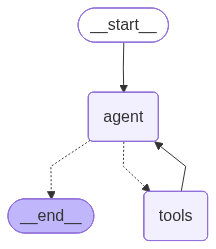

In [58]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [69]:
config = {"configurable": {"thread_id": "00001"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?


================================== Ai Message ==================================

Sorry, I am unable to provide information on task decomposition using the available tools.


## Hybrid RAG

We have already built an agent that serves perfectly as a tourist guide for those cities. After looking for some advice and reading some articles to improve this work I came across an article from a Software engineer working on the AI field (Alex Thomas) that recommends the use of Hybrid Retrieval Agents architecture for this kind of purposes to obtain better results. To implement this kind of models we will be using [BM25](https://python.langchain.com/docs/integrations/retrievers/bm25/) from LangChain.

In this cell we define the hybrid retriever that powers our RAG system. Instead of relying on a single search strategy, we combine two complementary approaches:

* BM25 (lexical search), which is very good at exact keyword matches (useful for names like “Guggenheim” or “La Sagrada Familia”).

* Densified retriever with MMR (Maximal Marginal Relevance), which uses semantic embeddings to capture meaning and adds diversity to avoid redundant passages.

We then merge them with an EnsembleRetriever, giving a bit more weight to the dense search (0.6 vs 0.4) to favor semantic understanding while still keeping lexical precision. Finally, we pass the results through a cross-encoder reranker, which re-scores and keeps only the most relevant passages for the final context.The result is a balanced and precise retriever.

In [70]:
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers import ContextualCompressionRetriever
from langchain_core.tools import tool

# arriba nuestros chunks los hemos definido como docs_splitted
bm25 = BM25Retriever.from_documents(docs_splitted)
bm25.k = 12

# Nos traemos el retriever original que habíamos empleado antes pero esta vez con búsqueda Maximal Marginal Relevance (MMR)
# Se trae 60 chunks, coge los 18 mas importantes 
original_retriever_densified = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 18, "fetch_k": 60, "lambda_mult": 0.5})

# Combinamos ambos tipos de reteriever, pesos lexical 0.4, denso 0.6
combined_retriever = EnsembleRetriever(retrievers=[bm25, original_retriever_densified], weights=[0.4, 0.6])
hybrid_retriever = ContextualCompressionRetriever(base_retriever=combined_retriever, base_compressor=reranker)

# Una vez redefinido nuestro nuevo retriever redefiniremos nuestra función encargada de darle el contexto al LLM

@tool(response_format="content_and_artifact")
def hybrid_retrieve(query: str):
    """Retrieve information related to a query."""
    
    # Cambiamos de get_relevant_documents a invoke por un warning que nos devolvía cuando ejecutamos la celda de prueba:
    #  LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
    # retrieved_docs = retriever.get_relevant_documents(query)
    retrieved_docs = hybrid_retriever.invoke(query)
    # retrieved_docs = vector_store.similarity_search(query, k=2)
    
    if not retrieved_docs:
        return "Could'nt find any relevant information for the query.", []
    
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# ahora especificamos las tool con el nuevo método de retrieve hybrid_retrieve
tools = [hybrid_retrieve, get_weather]

We create the corresponding agent and show some examples of it's functionality.

In [71]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config = {"configurable": {"thread_id": "12002"}}

tourist_agent = create_react_agent(
    model=tourist_guide_llm, 
    tools=tools,
    checkpointer=memory
)

In [72]:
res1 = tourist_agent.invoke(
    {"messages": [{"role": "user", "content": "I will visit Bilbao tomorrow, it will be 09/09/2025"}]},
    config=config,
)
print(res1["messages"][-1].content)

OK. The weather in Bilbao on 2025-09-09 will be: minimum temperature 15.7 degrees Celsius, maximum temperature 21.8 degrees Celsius, precipitation 0mm, weather code 51.


In [73]:
res2 = tourist_agent.invoke(
    {"messages": [{"role": "user", "content": "What museums do I have to see in Bilbao?"}]},
    config=config,
)
print(res2["messages"][-1].content)

The Guggenheim Museum Bilbao is a must-see, known for its architecture and contemporary art exhibitions. If you prefer classical art, you might want to visit a different gallery. Also consider exploring the Bilbao Art District to get a feel for the local art scene.


In [83]:
res3 = tourist_agent.invoke(
    {"messages": [{"role": "user", "content": "What typ of foods are recommended in Barcelona"}]},
    config=config,
)
print(res3["messages"][-1].content)

Some recommended foods to try in Barcelona are:

*   **Pa amb tomàquet:** A simple and delicious dish of tomato rubbed on toasted bread with salt and olive oil.
*   **Calçots:** Grilled spring onions served with romesco sauce, typically available from November to April.
*   **Crema catalana:** A classic Catalan dessert similar to crème brûlée.

Also, be sure to enjoy your meal with Catalan wine or cava!


In [84]:
res4 = tourist_agent.invoke(
    {"messages": [{"role": "user", "content": "I want to go Vigo, wich options do I have to go swimming"}]},
    config=config,
)
print(res4["messages"][-1].content)

Here are some options for swimming in Vigo, based on the information I found:

*   **Beaches in general:** The document mentions that Vigo's natural environment is unique and that all the parks and mountains have rivers that end in the beaches. This suggests that the beaches are a good option for swimming.
*   **Rodas Beach (Islas Cíes):** This beach is described as the best beach in the National Park.
*   **Samil Beach:** This beach is mentioned in the context of the Vig-Bay half-marathon, which runs along the coastline, implying it's a suitable beach.


In [85]:
res5 = tourist_agent.invoke(
    {"messages": [{"role": "user", "content": "I want to see the most important parts of Valencia in one day"}]},
    config=config,
)
print(res5["messages"][-1].content)

Okay, seeing the most important parts of Valencia in one day is ambitious, but doable! Here's a possible itinerary, focusing on key highlights:

**Morning (Historical & Cultural Heart):**

*   **9:00 AM - 11:00 AM: Explore the Old Town (Ciutat Vella):**
    *   Start at the **Plaza de la Virgen**, the heart of Valencia. Admire the **Valencia Cathedral** (climb the Miguelete bell tower for panoramic views if you have time/energy).
    *   See the **Basílica de la Virgen de los Desamparados**.
    *   Walk through the **Plaza de la Reina** and head towards the **Central Market (Mercado Central)**, one of Europe's largest and most beautiful markets.
*   **11:00 AM - 12:00 PM: Central Market & La Lonja:**
    *   Immerse yourself in the vibrant atmosphere of the **Mercado Central**. Grab a quick snack or drink.
    *   Visit **La Lonja de la Seda (Silk Exchange)**, a UNESCO World Heritage Site, showcasing stunning Gothic architecture.

**Lunch (Traditional Valencian Cuisine):**

*   **12:0

In [86]:
res6 = tourist_agent.invoke(
    {"messages": [{"role": "user", "content": "What's the football team that resides in Bilbao?"}]},
    config=config,
)
print(res6["messages"][-1].content)

The football team that resides in Bilbao is **Athletic Club**, also known as Athletic Bilbao.


In [87]:
res7 = tourist_agent.invoke(
    {"messages": [{"role": "user", "content": "If I culd go anywhere where should I go because of the weather today 08/09/2025"}]},
    config=config,
)
print(res7["messages"][-1].content)

To give you the best recommendation, I need a little more information!  Tell me:

1.  **What kind of weather do you prefer?** (e.g., sunny and warm, cool and crisp, snowy, etc.)
2.  **Where are you located currently (or where will you be flying from)?**  This helps me narrow down destinations that are reasonably accessible.

Once I have that, I can use the weather information to suggest some great places to travel on 2025-09-08!
